# Benchmarking of clustering methods 

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

## Hardware

- Sytem: Ubuntu 18.04.5 LTS
- CPU: Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz (12 cores)
- Disk: SAMSUNG MZ7LH960HAJR-00005 (SSD)
- RAM: 64G(32Gx2) DDR4 2666MHz
- GPU: RTX2080Ti (Driver Version: 495.29.05, CUDA Version: 11.5)

## Packages

- Python==3.7.8
- numpy==1.20.0
- scipy==1.5.1
- umap-learn==0.5.2
- sklearn==0.23.1
- matplotlib==3.2.2
- seaborn==0.10.1
- hdbscan==0.8.27
- openTSNE==0.6.1

## 0. Configure the environment

In [1]:
import time
import tracemalloc  # monitor memory usage
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import scipy.stats

# We use UMAP here
import umap  # this is CPU-based UMAP, use cuML for GPU version

# tested methods
import hdbscan
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
from sklearn.cluster import Birch

tracemalloc.start()

# for Linux only, load font file
mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

# load table, used column=motif_F10
df = pd.read_csv("./Fly_dev_table.motif.F10.csv", index_col=[0,1,2], header=[0,1])
# Prior knowledge: NSUN6-like TCNA, else, NSUN2-like
df[("INFO", "Priori")] = "Type I"
df.loc[df[("INFO", "motif")].isin(["TCCA", "TCTA", "TCGA", "TCAA"]), ("INFO", "Priori")] = "Type II"

enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCGN"])

def onehot_enc(row):
    seq = [[i] for i in row[("INFO", "motif_F10")].upper()]
    # print(enc.transform(seq).toarray().reshape(-1))
    return enc.transform(seq).toarray().reshape(-1)

onehot_input = []
for idx, row in df.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)


## 1. Generate UMAP

In [2]:
def UMAP(onehot_input, df):
    df = df.copy()
    # this should takes ~20 sec   
    print("UMAP")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=0.01, n_neighbors=20, verbose=True)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

_, _, df_UMAP = UMAP(onehot_input, df)

UMAP
UMAP(init='random', min_dist=0.01, n_neighbors=20, random_state=42, verbose=True)
Mon Jan 17 19:50:36 2022 Construct fuzzy simplicial set
Mon Jan 17 19:50:36 2022 Finding Nearest Neighbors
Mon Jan 17 19:50:36 2022 Building RP forest with 10 trees
Mon Jan 17 19:50:37 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	Stopping threshold met -- exiting after 6 iterations
Mon Jan 17 19:53:35 2022 Finished Nearest Neighbor Search
Mon Jan 17 19:53:38 2022 Construct embedding



Mon Jan 17 19:54:02 2022 Finished embedding
UMAP time: 205.3781545162201 sec
UMAP RAM: 79.28042221069336 MB



## 2. Test clustering methods

### 2.1 Partitioning methods 

### K-Means

In [3]:
def cluster_KMeans(df):
    df = df.copy()
    # very fast
    X = np.stack([df["X"], df["Y"]], axis=1)
    print("K-Means:")
    
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = KMeans(n_clusters=2, random_state=42).fit(X)
    model.fit(X)
    labels = model.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    print("K-Means time: {} sec".format(time1))
    print("K-Means RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    
    del model
    return time1, mem, df

t1, m1, _ = cluster_KMeans(df_UMAP)
t2, m2, _ = cluster_KMeans(df_UMAP)
t3, m3, df_KMeans = cluster_KMeans(df_UMAP)
KMeans_time = [t1, t2, t3]
KMeans_mem  = [m1, m2, m3]


K-Means:
K-Means time: 0.5592541694641113 sec
K-Means RAM: 42.333659172058105 Mb

K-Means:
K-Means time: 0.1942577362060547 sec
K-Means RAM: 36.62017059326172 Mb

K-Means:
K-Means time: 0.22028613090515137 sec
K-Means RAM: 36.61672401428223 Mb



### Gaussian Mixture Model (GMM)

In [4]:
def cluster_GMM(df):
    # very fast
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = GaussianMixture(n_components=2, init_params="random", random_state=42).fit(X)
    model.fit(X)
    labels = model.predict(X)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    print("GMM time: {} sec".format(time1))
    print("GMM RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    
    del model
    return time1, mem, df

t1, m1, _ = cluster_GMM(df_UMAP)
t2, m2, _ = cluster_GMM(df_UMAP)
t3, m3, df_GMM = cluster_GMM(df_UMAP)
GMM_time = [t1, t2, t3]
GMM_mem  = [m1, m2, m3]

GMM time: 0.02910470962524414 sec
GMM RAM: 30.925734519958496 Mb

GMM time: 0.03015875816345215 sec
GMM RAM: 30.86933708190918 Mb

GMM time: 0.02779841423034668 sec
GMM RAM: 30.86768913269043 Mb



### 2.2 Graph-based methods

### Spectral Clustering

In [5]:
def cluster_SpectralClustering(df):
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = SpectralClustering(n_clusters=2, gamma=1, n_jobs=6)
    labels = model.fit_predict(X)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    print("SpectralClustering time: {} sec".format(time1))
    print("SpectralClustering RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    
    del model
    return time1, mem, df

t1, m1, _ = cluster_SpectralClustering(df_UMAP)
t2, m2, _ = cluster_SpectralClustering(df_UMAP)
t3, m3, df_SpectralClustering = cluster_SpectralClustering(df_UMAP)
SpectralClustering_time = [t1, t2, t3]
SpectralClustering_mem  = [m1, m2, m3]

SpectralClustering time: 8.274160385131836 sec
SpectralClustering RAM: 2155.0121421813965 Mb

SpectralClustering time: 8.501247882843018 sec
SpectralClustering RAM: 2154.6428480148315 Mb

SpectralClustering time: 8.436224937438965 sec
SpectralClustering RAM: 2154.64181804657 Mb



### 2.3 Hierarchical methods

### Agglomerative Clustering

In [6]:
def cluster_AgglomerativeClustering(df, linkage="complete"):
    # ~1 sec
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = AgglomerativeClustering(linkage=linkage, n_clusters=2)
    labels = model.fit_predict(X)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    print("AgglomerativeClustering time: {} sec".format(time1))
    print("AgglomerativeClustering RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    
    del model
    return time1, mem, df

t1, m1, _ = cluster_AgglomerativeClustering(df_UMAP)
t2, m2, _ = cluster_AgglomerativeClustering(df_UMAP)
t3, m3, df_AgglomerativeClustering = cluster_AgglomerativeClustering(df_UMAP)
AgglomerativeClustering_time = [t1, t2, t3]
AgglomerativeClustering_mem  = [m1, m2, m3]

AgglomerativeClustering time: 1.9549672603607178 sec
AgglomerativeClustering RAM: 2148.9490242004395 Mb

AgglomerativeClustering time: 1.9527697563171387 sec
AgglomerativeClustering RAM: 2148.9025115966797 Mb

AgglomerativeClustering time: 1.9257502555847168 sec
AgglomerativeClustering RAM: 2148.901123046875 Mb



### BIRCH

In [7]:
def cluster_BIRCH(df):
    # ~1 sec
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = Birch(n_clusters=2)
    labels = model.fit_predict(X)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    print("BIRCH  time: {} sec".format(time1))
    print("BIRCH  RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    
    del model
    return time1, mem, df

t1, m1, _ = cluster_BIRCH(df_UMAP)
t2, m2, _ = cluster_BIRCH(df_UMAP)
t3, m3, df_BIRCH = cluster_BIRCH(df_UMAP)
BIRCH_time = [t1, t2, t3]
BIRCH_mem  = [m1, m2, m3]

BIRCH  time: 0.3192458152770996 sec
BIRCH  RAM: 2143.190071105957 Mb

BIRCH  time: 0.3205857276916504 sec
BIRCH  RAM: 2143.156018257141 Mb

BIRCH  time: 0.32746195793151855 sec
BIRCH  RAM: 2143.13747882843 Mb



### 2.4 Density-based methods

### OPTICS

In [8]:
def cluster_OPTICS(df):
    # ~ 12 sec
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05) # , n_jobs=4
    model.fit(X)
    labels = model.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    print("OPTICS time: {} sec".format(time1))
    print("OPTICS RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    
    del model
    return time1, mem, df

t1, m1, _ = cluster_OPTICS(df_UMAP)
t2, m2, _ = cluster_OPTICS(df_UMAP)
t3, m3, df_OPTICS = cluster_OPTICS(df_UMAP)
OPTICS_time = [t1, t2, t3]
OPTICS_mem  = [m1, m2, m3]

OPTICS time: 9.876356363296509 sec
OPTICS RAM: 2137.3884086608887 Mb

OPTICS time: 9.881254434585571 sec
OPTICS RAM: 2136.97869682312 Mb

OPTICS time: 9.833130836486816 sec
OPTICS RAM: 2136.8722019195557 Mb



### DBSCAN

In [9]:
def cluster_DBSCAN(df):
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = DBSCAN(eps=0.4, min_samples=100, n_jobs=6)
    labels = model.fit_predict(X)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    print("DBSCAN time: {} sec".format(time1))
    print("DBSCAN RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    del model
    return time1, mem, df

t1, m1, _ = cluster_DBSCAN(df_UMAP)
t2, m2, _ = cluster_DBSCAN(df_UMAP)
t3, m3, df_DBSCAN = cluster_DBSCAN(df_UMAP)
DBSCAN_time = [t1, t2, t3]
DBSCAN_mem  = [m1, m2, m3]

DBSCAN time: 0.1374647617340088 sec
DBSCAN RAM: 2131.0563774108887 Mb

DBSCAN time: 0.13530397415161133 sec
DBSCAN RAM: 2131.1202030181885 Mb

DBSCAN time: 0.1376502513885498 sec
DBSCAN RAM: 2131.1121253967285 Mb



### HDBSCAN

In [10]:
def cluster_HDBSCAN(df):
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=1, cluster_selection_epsilon=100.0, cluster_selection_method='eom', core_dist_n_jobs=6)
    labels = model.fit(X).labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    print("HDBSCAN time: {} sec".format(time1))
    print("HDBSCAN RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    del model
    return time1, mem, df

t1, m1, _ = cluster_HDBSCAN(df_UMAP)
t2, m2, _ = cluster_HDBSCAN(df_UMAP)
t3, m3, df_HDBSCAN = cluster_HDBSCAN(df_UMAP)
HDBSCAN_time = [t1, t2, t3]
HDBSCAN_mem  = [m1, m2, m3]

HDBSCAN time: 0.28966188430786133 sec
HDBSCAN RAM: 2125.395182609558 Mb

HDBSCAN time: 0.2537672519683838 sec
HDBSCAN RAM: 2125.23664188385 Mb

HDBSCAN time: 0.24853253364562988 sec
HDBSCAN RAM: 2125.236018180847 Mb



### HDBSCAN (soft clustering)

In [11]:
def cluster_HDBSCAN_softclustering(df):
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=1, cluster_selection_method='eom', core_dist_n_jobs=6, prediction_data=True)
    yhat = model.fit(X)
    
    soft_clusters = hdbscan.all_points_membership_vectors(yhat)
    labels = [np.argmax(x) for x in soft_clusters] 
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    df["Cluster"] = labels
    del model
    return time1, mem, df

t1, m1, _ = cluster_HDBSCAN_softclustering(df_UMAP)
t2, m2, _ = cluster_HDBSCAN_softclustering(df_UMAP)
t3, m3, df_HDBSCAN_soft = cluster_HDBSCAN_softclustering(df_UMAP)
HDBSCAN_soft_time = [t1, t2, t3]
HDBSCAN_soft_mem  = [m1, m2, m3]

HDBSCAN soft clustering time: 0.9324474334716797 sec
HDBSCAN soft clustering RAM: 2119.5220794677734 Mb

HDBSCAN soft clustering time: 0.9528086185455322 sec
HDBSCAN soft clustering RAM: 2119.5195350646973 Mb

HDBSCAN soft clustering time: 0.9584450721740723 sec
HDBSCAN soft clustering RAM: 2119.5184593200684 Mb



## 3. Benchmarking

### 3.1 Comparing runtime

                       Method  Time (seconds)
0                     K-Means        0.559254
1                     K-Means        0.194258
2                     K-Means        0.220286
3                         GMM        0.029105
4                         GMM        0.030159
5                         GMM        0.027798
6         Spectral Clustering        8.274160
7         Spectral Clustering        8.501248
8         Spectral Clustering        8.436225
9    Agglomerative Clustering        1.954967
10   Agglomerative Clustering        1.952770
11   Agglomerative Clustering        1.925750
12                      BIRCH        0.319246
13                      BIRCH        0.320586
14                      BIRCH        0.327462
15                     OPTICS        9.876356
16                     OPTICS        9.881254
17                     OPTICS        9.833131
18                     DBSCAN        0.137465
19                     DBSCAN        0.135304
20                     DBSCAN     

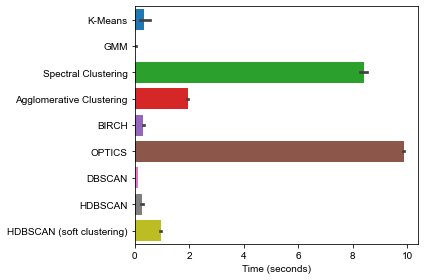

In [12]:
fig, ax = plt.subplots()
df_time = pd.DataFrame([KMeans_time, GMM_time, SpectralClustering_time, AgglomerativeClustering_time, BIRCH_time, OPTICS_time, DBSCAN_time, HDBSCAN_time, HDBSCAN_soft_time], index=["K-Means", "GMM", "Spectral Clustering", "Agglomerative Clustering", "BIRCH", "OPTICS", "DBSCAN", "HDBSCAN", "HDBSCAN (soft clustering)"]).T
df_time = df_time.melt(var_name="Method", value_name="Time (seconds)")

# saving results to disk
df_time.to_csv("Clustering_runtime.csv")

print(df_time)
sns.barplot(data=df_time, y="Method", x="Time (seconds)", orient="h", ax=ax, saturation=1)
ax.set_ylabel("")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("Clustering_runtime.pdf")

### 3.2 Memory Usage

                       Method  Peak Memory (MB)
0                     K-Means         42.333659
1                     K-Means         36.620171
2                     K-Means         36.616724
3                         GMM         30.925735
4                         GMM         30.869337
5                         GMM         30.867689
6         Spectral Clustering       2155.012142
7         Spectral Clustering       2154.642848
8         Spectral Clustering       2154.641818
9    Agglomerative Clustering       2148.949024
10   Agglomerative Clustering       2148.902512
11   Agglomerative Clustering       2148.901123
12                      BIRCH       2143.190071
13                      BIRCH       2143.156018
14                      BIRCH       2143.137479
15                     OPTICS       2137.388409
16                     OPTICS       2136.978697
17                     OPTICS       2136.872202
18                     DBSCAN       2131.056377
19                     DBSCAN       2131

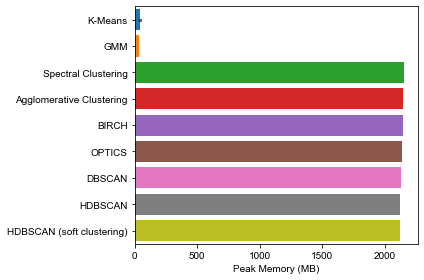

In [13]:
fig, ax = plt.subplots()
df_mem = pd.DataFrame([KMeans_mem, GMM_mem, SpectralClustering_mem, AgglomerativeClustering_mem, BIRCH_mem, OPTICS_mem, DBSCAN_mem, HDBSCAN_mem, HDBSCAN_soft_mem], index=["K-Means", "GMM", "Spectral Clustering", "Agglomerative Clustering", "BIRCH", "OPTICS", "DBSCAN", "HDBSCAN", "HDBSCAN (soft clustering)"]).T
df_mem = df_mem.melt(var_name="Method", value_name="Peak Memory (MB)")

# saving results to disk
df_mem.to_csv("Clustering_Memory.csv")

print(df_mem)
sns.barplot(data=df_mem, y="Method", x="Peak Memory (MB)", orient="h", ax=ax, saturation=1)
ax.set_ylabel("")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("Clustering_Memory.pdf")

### 3.3 Draw Scatters

In [14]:
def draw_clusters(ax, df, xlabel, ylabel, title, compute_consistency=True):
    clusters = set(df["Cluster"].tolist())
    
    for i in clusters:
        subdf = df[df["Cluster"]==i]
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=1, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=1, alpha=1, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    df.to_csv("{}.csv".format(title.replace(" ","_")))

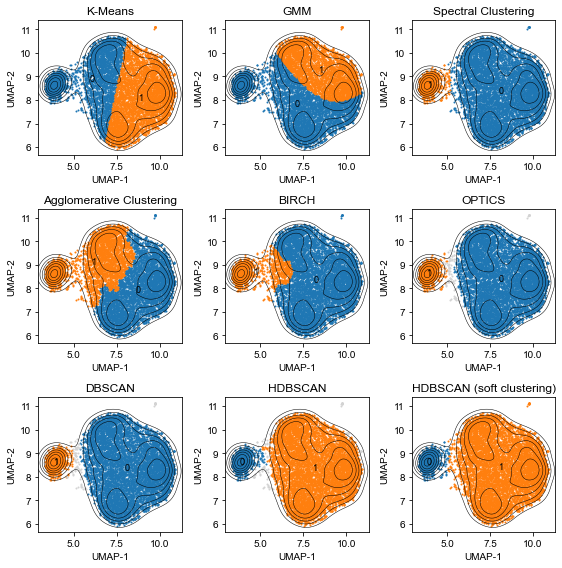

In [15]:
fig, axes = plt.subplots(3,3, figsize=(8,8))
draw_clusters(axes[0][0], df_KMeans, "UMAP-1", "UMAP-2", "K-Means")
draw_clusters(axes[0][1], df_GMM, "UMAP-1", "UMAP-2", "GMM")
draw_clusters(axes[0][2], df_SpectralClustering, "UMAP-1", "UMAP-2", "Spectral Clustering")

draw_clusters(axes[1][0], df_AgglomerativeClustering, "UMAP-1", "UMAP-2", "Agglomerative Clustering")
draw_clusters(axes[1][1], df_BIRCH, "UMAP-1", "UMAP-2", "BIRCH")
draw_clusters(axes[1][2], df_OPTICS, "UMAP-1", "UMAP-2", "OPTICS")

draw_clusters(axes[2][0], df_DBSCAN, "UMAP-1", "UMAP-2", "DBSCAN")
draw_clusters(axes[2][1], df_HDBSCAN, "UMAP-1", "UMAP-2", "HDBSCAN")
draw_clusters(axes[2][2], df_HDBSCAN_soft, "UMAP-1", "UMAP-2", "HDBSCAN (soft clustering)")
plt.tight_layout()

plt.savefig("Clustering_scatter.pdf")

### 3.4 Compute consistency 

In [16]:
def cal_Precsion_Recall(df, name, predict_type=[0, 1], expected_type=["Type I", "Type II"]):
    # firstly, get confusion matrix
    exp_values = []
    for i in df[("INFO", "Priori")]:
        if i == expected_type[0]:
            exp_values.append(0)
        else:
            exp_values.append(1)
    pred_values = []
    for i in df["Cluster"]:
        if i == predict_type[0]:
            pred_values.append(0)
        elif i == predict_type[1]:
            pred_values.append(1)
        elif i == -1:
            pred_values.append(-1)
    matrix = metrics.confusion_matrix(exp_values, pred_values)
    if matrix.shape[0] == 3:
        confusion_matrix = pd.DataFrame(matrix, index=[-1, 0, 1], columns=[-1,0,1])
    else:
        confusion_matrix = pd.DataFrame(matrix, index=[0, 1], columns=[0,1])
    
    TP1 = confusion_matrix.loc[0, 0]
    TP2 = confusion_matrix.loc[1, 1]
    
    FP1 = confusion_matrix[0].sum() - TP1
    FP2 = confusion_matrix[1].sum() - TP2
    
    TN1 = confusion_matrix.sum().sum() - confusion_matrix[0].sum() - confusion_matrix.loc[0].sum() + TP1
    TN2 = confusion_matrix.sum().sum() - confusion_matrix[1].sum() - confusion_matrix.loc[1].sum() + TP2
    
    FN1 = confusion_matrix.loc[0].sum() - TP1
    FN2 = confusion_matrix.loc[1].sum() - TP2
    
    Recall_1 = TP1/(TP1+FN1+0.0)
    Precision_1 = TP1/(TP1+FP1+0.0)
    
    Recall_2 = TP2/(TP2+FN2+0.0)
    Precision_2 = TP2/(TP2+FP2+0.0)
    print(name)
    print(confusion_matrix)
    print("===============================")
    return name, Recall_1, Precision_1, Recall_2, Precision_2


In [17]:
Precision_Recall_data = []
Precision_Recall_data.append(cal_Precsion_Recall(df_KMeans, "K-Means", predict_type=[1, 0]))
Precision_Recall_data.append(cal_Precsion_Recall(df_GMM, "GMM", predict_type=[1, 0]))
Precision_Recall_data.append(cal_Precsion_Recall(df_SpectralClustering, "Spectral Clustering"))

Precision_Recall_data.append(cal_Precsion_Recall(df_AgglomerativeClustering, "Agglomerative Clustering"))
Precision_Recall_data.append(cal_Precsion_Recall(df_BIRCH, "BIRCH"))
Precision_Recall_data.append(cal_Precsion_Recall(df_OPTICS, "OPTICS"))

Precision_Recall_data.append(cal_Precsion_Recall(df_DBSCAN, "DBSCAN"))
Precision_Recall_data.append(cal_Precsion_Recall(df_HDBSCAN, "HDBSCAN", predict_type=[1, 0]))
Precision_Recall_data.append(cal_Precsion_Recall(df_HDBSCAN_soft, "HDBSCAN (soft clustering)", predict_type=[1, 0]))

K-Means
      0     1
0  4793  2848
1     0   761
GMM
      0     1
0  3500  4141
1     0   761
Spectral Clustering
      0    1
0  7515  126
1     4  757
Agglomerative Clustering
      0     1
0  4893  2748
1     1   760
BIRCH
      0    1
0  7016  625
1     1  760
OPTICS
    -1     0    1
-1   0     0    0
 0  78  7462  101
 1   5     3  753
DBSCAN
    -1     0    1
-1   0     0    0
 0  75  7468   98
 1   4     3  754
HDBSCAN
    -1     0    1
-1   0     0    0
 0  80  7451  110
 1   2     3  756
HDBSCAN (soft clustering)
      0    1
0  7524  117
1     5  756


In [18]:
df_Precision_Recall = pd.DataFrame(Precision_Recall_data, columns=["Method", "Recall (Type I)", "Precision (Type I)", "Recall (Type II)", "Precision (Type II)"])

df_Precision = df_Precision_Recall[["Method", "Precision (Type I)", "Precision (Type II)"]]
df_Precision.columns = ["Method", "Type I", "Type II"]
df_Precision = df_Precision.melt(id_vars=["Method"], var_name="m5C Type")
df_Precision["Metric"] = "Precision"

df_Recall = df_Precision_Recall[["Method", "Recall (Type I)", "Recall (Type II)"]]
df_Recall.columns = ["Method", "Type I", "Type II"]
df_Recall = df_Recall.melt(id_vars=["Method"], var_name="m5C Type")
df_Recall["Metric"] = "Recall"

df_Precision_Recall = pd.concat([df_Precision, df_Recall])
df_Precision_Recall.to_csv("Clustering.metrics.csv")

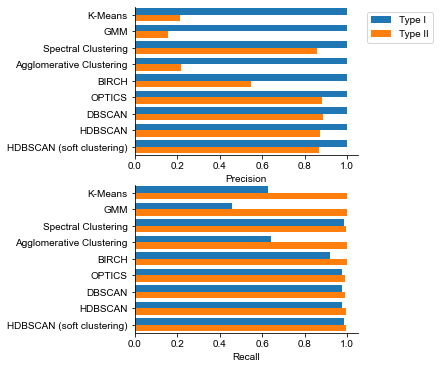

In [19]:
fig, axes = plt.subplots(2,1, figsize=(4,6))
_ = sns.barplot(data=df_Precision, y="Method", x="value", hue="m5C Type", ax=axes[0], saturation=1, orient="h")
axes[0].legend(bbox_to_anchor=(1.02,1))
axes[0].set_xlabel("Precision")

_ = sns.barplot(data=df_Recall, y="Method", x="value", hue="m5C Type", ax=axes[1], saturation=1, orient="h")
axes[1].legend_.remove()
axes[1].set_xlabel("Recall")
axes[0].set_ylabel("")
axes[1].set_ylabel("")
sns.despine()
plt.savefig("Cluster_methods_Precision_Recall.pdf")